In [78]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [79]:
df = pd.read_csv('/content/Twitter.csv', encoding='latin-1')
df.head()

,Brand,Sentiment,Text
0,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,Borderlands,Positive,I am coming to the borders and I will kill you...
2,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,Borderlands,Positive,im coming on borderlands and i will murder you...
4,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [80]:
# Preprocessing
df = df[['Text', 'Brand', 'Sentiment']]  # Select relevant columns
df.dropna(inplace=True)  # Remove rows with missing values

<ipython-input-80-af6ac83bd871>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)  # Remove rows with missing values


In [81]:
# Encode categorical features
le_brand = LabelEncoder()
df['Brand'] = le_brand.fit_transform(df['Brand'])
le_sentiment = LabelEncoder()
df['Sentiment'] = le_sentiment.fit_transform(df['Sentiment'])

In [82]:
# Tokenize text data
max_words = 10000  # Adjust as needed
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df['Text'])
sequences = tokenizer.texts_to_sequences(df['Text'])

In [83]:
# Pad sequences to ensure uniform length
max_sequence_length = 100  # Adjust as needed
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length)

In [84]:
# Split data into training and testing sets
X = np.array(padded_sequences)
y = np.array(df['Sentiment'])
brand = np.array(df['Brand']) # Include Brand as a feature
X_train, X_test, y_train, y_test, brand_train, brand_test = train_test_split(X, y, brand, test_size=0.2, random_state=42)

In [85]:
# Model building
model = Sequential()
model.add(Embedding(max_words, 128, input_length=max_sequence_length))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2)) #added dropout for regularization
model.add(Dense(64, activation='relu')) #added a dense layer
# Change activation to 'softmax' for multi-class classification
model.add(Dense(4, activation='softmax'))  # Assuming 4 sentiment classes (0, 1, 2, 3) Adjust if needed

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [86]:
# Compile the model with 'categorical_crossentropy' for multi-class
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy']) #changed to sparse_categorical_crossentropy loss

In [75]:
model.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/5
925/925 ━━━━━━━━━━━━━━━━━━━━ 162s 169ms/step - accuracy: 0.5099 - loss: 1.1197 - val_accuracy: 0.7305 - val_loss: 0.7109
Epoch 2/5
925/925 ━━━━━━━━━━━━━━━━━━━━ 203s 170ms/step - accuracy: 0.7791 - loss: 0.5889 - val_accuracy: 0.7857 - val_loss: 0.5682
Epoch 3/5
925/925 ━━━━━━━━━━━━━━━━━━━━ 202s 171ms/step - accuracy: 0.8435 - loss: 0.4167 - val_accuracy: 0.8134 - val_loss: 0.5123
Epoch 4/5
925/925 ━━━━━━━━━━━━━━━━━━━━ 200s 169ms/step - accuracy: 0.8787 - loss: 0.3180 - val_accuracy: 0.8259 - val_loss: 0.4940
Epoch 5/5
925/925 ━━━━━━━━━━━━━━━━━━━━ 200s 166ms/step - accuracy: 0.8982 - loss: 0.2661 - val_accuracy: 0.8347 - val_loss: 0.4956


In [76]:
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

463/463 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.8312 - loss: 0.5101
Test Loss: 0.4956231117248535
Test Accuracy: 0.8347297310829163


In [87]:
# Predict on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels

463/463 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step


In [88]:
# Classification Report
print(classification_report(y_test, y_pred_classes))

              precision    recall  f1-score   support

           0       0.19      0.28      0.23      2696
           1       0.33      0.14      0.20      4380
           2       0.22      0.40      0.29      3605
           3       0.25      0.15      0.19      4119

    accuracy                           0.23     14800
   macro avg       0.25      0.24      0.23     14800
weighted avg       0.26      0.23      0.22     14800



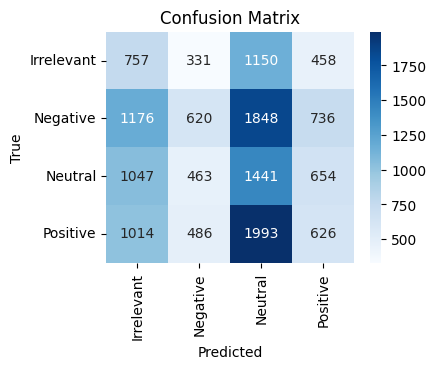

In [90]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le_sentiment.classes_, yticklabels=le_sentiment.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()